# In this notebook.
I figured out how to create a model that works (the batch size needs to be small so that the gradients most important for predicting high aqi days are visited). 

I also got my first model of the PFA model to work, which is a huge step forward in this project!

In [10]:
import os
import re
import pandas as pd
import numpy as np
from datetime import datetime
import joblib
from functools import lru_cache

from nltk.tokenize import TweetTokenizer
import spacy
import nltk
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader


In [2]:
portland_dir = '/hpc/group/carlsonlab/zdc6/wildfire/data/portland/'

In [3]:
files = []
for f in os.listdir(portland_dir):
    if re.search('csv', f):
        files.append(pd.read_csv(portland_dir+f))
        
df = pd.concat(files)

In [4]:
# Add in the AQI to the dataframe
aqi = pd.read_csv('/hpc/group/carlsonlab/zdc6/wildfire/data/daily_aqi_by_county_2020.csv')
aqi_df = aqi[
    (aqi['State Name'] == 'Oregon') & (aqi['county Name'] == 'Multnomah')
][['Date', 'AQI']]
aqi_df['Date'] = pd.to_datetime(aqi_df['Date'], format='%Y-%m-%d').apply(datetime.date)

get_aqi = aqi_df.set_index("Date").to_dict().get("AQI")
lemmatized = joblib.load(portland_dir+'cached/lemmatized.joblib')
df['lemmatized'] = lemmatized

In [5]:
df['date'] = df['created_at'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['date'])

In [57]:
count_vec = CountVectorizer(stop_words='english', min_df=50, max_df=0.1)

x_train_cv = count_vec.fit_transform(train_df['lemmatized'])
x_test_cv = count_vec.transform(test_df['lemmatized'])

dates = list(set(train_df['date']))

x_dict ={}
xtest_dict ={}

for d in dates:
    x_dict[d] = x_train_cv[train_df['date'] == d]
    xtest_dict[d] = x_test_cv[test_df['date'] == d]

In [12]:
class TweetDataset(Dataset):
    
    def __init__(self, cv_dict, agg_count=1000, sample_rate=30, random_state=42):

        self.dates = list(cv_dict.keys())
        self.agg_count = agg_count
        self.sample_rate = sample_rate
        self.generator = np.random.default_rng(seed=random_state)
        self.count_vecs = cv_dict
        
    def __len__(self):
        return len(self.dates) * self.sample_rate
    
    @lru_cache(maxsize=None)
    def __getitem__(self, idx):
        
        date = self.dates[idx % len(self.dates)]
        
        sample = self.generator.choice(self.count_vecs[date].toarray(), self.agg_count, replace=True)
        
        return (
            torch.from_numpy(sample.sum(axis=0)).float().requires_grad_(False),
                            torch.tensor(np.log10(get_aqi[date]))
        )

In [76]:
class simple(nn.Module):
    
    def __init__(self, vocab):
        super().__init__()
        
        self.fc1 = nn.Linear(vocab, 100)
        self.fc2 = nn.Linear(100, 1)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2(h1)
    
    def loss_function(self, y, y_hat):
        MSE = (y - y_hat).pow(2).mean()
        return MSE

In [69]:
X_train = TweetDataset(x_dict)
X_test = TweetDataset(xtest_dict, sample_rate=5)

train_loader = DataLoader(X_train, batch_size=1)
test_loader = DataLoader(X_test, batch_size=1)

In [117]:

device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
    
vocab_size = len(count_vec.vocabulary_)

model = simple(vocab_size)#, num_components=20, prior_mean=1)
model.to(device)

EPOCHS = 30
print_rate = 300

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [126]:
loss_results = {
        "train": [],
        "val": []
    }

for epoch in range(EPOCHS):
    epoch_train_loss = 0
    epoch_test_loss = 0
    # Run method on training
    model.train()
    for batch_idx, (data, y) in enumerate(train_loader):
        # Add training data to GPU
        data = data.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_hat = model(data)
        
        y_hat = y_hat.to(device)
        
        loss = model.loss_function(y, y_hat)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        if batch_idx % print_rate == 0:
            print(
                "Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
    print(
        "===> Epoch: {} Average Loss: {:.4f}".format(
            epoch, epoch_train_loss / batch_idx
        )
    )
    loss_results['train'].append(epoch_train_loss/batch_idx)

    # loss['train'].append(epoch_train_loss)

    # Capture testing performance.
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, y) in enumerate(test_loader):
            # Add to GPU
            data = data.to(device)
            y = y.to(device)
            y_hat = model(data)
            loss = model.loss_function(y, y_hat)
            epoch_test_loss += loss.item()

    epoch_test_loss /= batch_idx
    if epoch_test_loss < 0.05:
        break
    # Append results to the json
    loss_results["val"].append(epoch_test_loss)

    print("===> Test set loss: {:.4f}".format(epoch_test_loss))

Train epoch: 0 [0/1830 (0%)]	Loss: 0.018438
Train epoch: 0 [300/1830 (16%)]	Loss: 0.002222
Train epoch: 0 [600/1830 (33%)]	Loss: 0.000903
Train epoch: 0 [900/1830 (49%)]	Loss: 0.007904
Train epoch: 0 [1200/1830 (66%)]	Loss: 0.006727
Train epoch: 0 [1500/1830 (82%)]	Loss: 0.018064
Train epoch: 0 [1800/1830 (98%)]	Loss: 0.009956
===> Epoch: 0 Average Loss: 0.0077


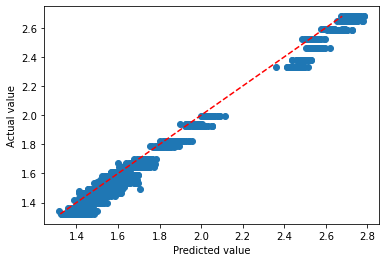

In [127]:
model.eval()
y_vals = []
y_preds = []
for x, y in train_loader:
    x = x.to(device)
    y_vals.append(y)
    y_hat = model(x)
    y_preds.append(y_hat)
    
y_vals = torch.cat(y_vals).cpu().detach()
y_preds = torch.cat(y_preds).cpu().detach()
perfect = np.linspace(min(y_vals), max(y_vals), 100)
plt.plot(perfect, perfect, '--', color='red')
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.scatter(y_preds, y_vals)

In [128]:
r2_score(y_preds, y_vals)

0.9701979306871829

In [121]:
(y_preds-y_vals).pow(2).mean()

tensor(0.2857, dtype=torch.float64)

In [115]:
y_vals.shape

torch.Size([1830])

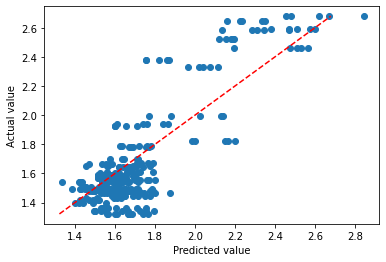

In [129]:
model.eval()
y_vals = []
y_preds = []
for x, y in test_loader:
    x = x.to(device)
    y_vals.append(y)
    y_hat = model(x)
    y_preds.append(y_hat)
    
y_vals = torch.cat(y_vals).cpu().detach()
y_preds = torch.cat(y_preds).cpu().detach()
perfect = np.linspace(min(y_vals), max(y_vals), 100)
plt.plot(perfect, perfect, '--', color='red')
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.scatter(y_preds, y_vals)

In [130]:
(y_preds-y_vals).pow(2).mean()

tensor(0.2002, dtype=torch.float64)

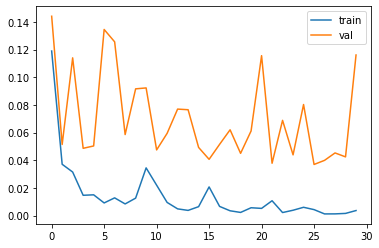

In [124]:
plt.plot(range(EPOCHS), loss_results['train'], label='train')
plt.plot(range(EPOCHS), loss_results['val'], label='val')
plt.legend()
plt.show()

In [131]:
from sklearn.metrics import r2_score

r2_score(y_preds, y_vals)

0.46434518165624883

In [230]:
class VAE(nn.Module):
    """
    Should rename -- PFA for Poisson Factor Analysis
    """

    def __init__(self, vocab, num_components=20, prior_mean=0, prior_logvar=0):
        """
        Inputs
        --------
        vocab<int>: the size of the vocabulary

        This model only has the variational layer, then the output
        to the reconstruction. At this point, there are no hidden layers.
        """
        super().__init__()
        self.num_components = num_components

        self.prior_mean = torch.tensor(prior_mean)
        self.prior_logvar = torch.tensor(prior_logvar)

        self.enc_logvar = nn.Linear(vocab, num_components, bias=False)
        self.enc_mu = nn.Linear(vocab, num_components, bias=False)
        self.W_tilde = torch.rand(num_components, vocab, requires_grad=True)
        self.pois_nll = nn.PoissonNLLLoss(log_input=False)
        self.softplus = nn.Softplus()

        self.beta = nn.Linear(1, 1, bias=True)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu = self.enc_mu(x)
        logvar = self.enc_logvar(x)

        s_tilde = self.reparameterize(mu, logvar)

        s = self.softplus(s_tilde)
        W = self.softplus(self.W_tilde)

        # Predict y using the first node from s
        y_hat = self.beta(s[:,0])

        return s, W, mu, logvar, y_hat

    def get_topic_dist(self, x):
        """
        When it comes to looking at the norm, we want to calculate the
        probability that a certain sample belongs to each topic.
        """
        s, _ = self.encode(x)
        W = self.parameters()  # TODO - figure out which parameters to add.
        norm = torch.norm(s @ W, p=1)  # Return the L1 norm
        # TODO -- add in the multinomial distribution.

        # TODO - need to calculate elementwise product.
        return s @ W / norm

    def _kl_divergence(self, mean, logvar):
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        # BUT...
        # Code extended to handle a more informative prior
        # Referencing this derivation found here:
        # https://stanford.edu/~jduchi/projects/general_notes.pdf
        # Assume diagonal matrices for variance
        KLD = -0.5 * torch.sum(
            1
            + logvar
            - self.prior_logvar
            - (mean - self.prior_mean) ** 2 / self.prior_logvar.exp()
            - logvar.exp() / self.prior_logvar.exp()
        )

        return KLD

    def loss_function(self, recon_x, x, mu, logvar, y, y_hat):
        KLD = self._kl_divergence(mu, logvar)
        PNLL = self.pois_nll(recon_x, x)
        # This will disproportionately weight higher values of y
        MSE = (y - y_hat).pow(2).mean()
        return PNLL, MSE, KLD

    @torch.no_grad()
    def reconstruct(self, X):
        s, W, mu, logvar = self.forward(X)

        return s @ W

In [133]:
X_train = TweetDataset(x_dict)
X_test = TweetDataset(xtest_dict, sample_rate=5)

train_loader = DataLoader(X_train, batch_size=1)
test_loader = DataLoader(X_test, batch_size=1)

In [255]:

device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
    
vocab_size = len(count_vec.vocabulary_)

prior_logvar = torch.log(torch.tensor(10, requires_grad=False))

model = VAE(vocab_size, num_components=200, prior_mean=5, prior_logvar=prior_logvar)
model.to(device)

EPOCHS = 100
print_rate = 300

optimizer = optim.Adam(model.parameters(), lr=1e-6)

PNLL_WEIGHT = 0.1
KLD_WEIGHT = 0.00001

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
loss_results = {
        "train": {"pnll": [], "mse": [], "kld": [], "total": []},
        "val": {"pnll": [], "mse": [], "kld": [], "total": []},
    }

for epoch in range(EPOCHS):
    epoch_train_loss = 0
    epoch_test_loss = 0
    # Run method on training
    model.train()
    avg_pnll = 0
    avg_mse = 0
    avg_kld = 0
    for batch_idx, (data, y) in enumerate(train_loader):
        # Add training data to GPU
        data = data.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        s, W, mu, logvar, y_hat = model(data)
        s = s.to(device)
        W = W.to(device)
        y_hat = y_hat.to(device)
        recon_batch = s @ W  # Calculate the reconstructed matrix
        recon_batch = recon_batch.to(device)
        mu = mu.to(device)
        logvar = logvar.to(device)
        PNLL, MSE, KLD = model.loss_function(
            recon_batch, data, mu, logvar, y, y_hat
        )

        loss = PNLL_WEIGHT*PNLL + MSE + KLD_WEIGHT * KLD
        loss.backward()
        optimizer.step()
        avg_pnll += PNLL_WEIGHT*PNLL.item()
        avg_mse += MSE.item()
        avg_kld += KLD_WEIGHT*KLD.item()
        epoch_train_loss += loss.item()

        if batch_idx % print_rate == 0:
            print(
                "Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
    print(
        "===> Epoch: {} Average Loss: {:.4f}".format(
            epoch, epoch_train_loss / (batch_idx+1)
        )
    )
    loss_results["train"]["pnll"].append(avg_pnll / (batch_idx+1))
    loss_results["train"]["mse"].append(avg_mse / (batch_idx+1))
    loss_results["train"]["kld"].append(avg_kld / (batch_idx+1))
    loss_results["train"]["total"].append(
        epoch_train_loss / (batch_idx+1)
    )

    # loss['train'].append(epoch_train_loss)

    # Capture testing performance.
    model.eval()
    frobenius_norms = []
    poisson = []
    mean_squared_error = []
    kl_divergence = []
    avg_pnll = 0
    avg_mse = 0
    avg_kld = 0
    with torch.no_grad():
        for batch_idx, (data, y) in enumerate(test_loader):
            # Add to GPU
            data = data.to(device)
            y = y.to(device)
            s, W, mu, logvar, y_hat = model(data)
            s = s.to(device)
            W = W.to(device)
            recon_batch = s @ W
            PNLL, MSE, KLD = model.loss_function(
                recon_batch, data, mu, logvar, y, y_hat
            )
            loss = PNLL_WEIGHT*PNLL + MSE + KLD_WEIGHT * KLD
            avg_pnll += PNLL_WEIGHT*PNLL.item()
            avg_mse += MSE.item()
            avg_kld += KLD_WEIGHT*KLD.item()
            epoch_test_loss += loss.item()

            # Calculate frobenius norm of the reconstructed matrix
            frobenius_norms.append(
                torch.norm(recon_batch - data, p="fro", dim=1).mean().item()
            )
            mean_squared_error.append(MSE)
            kl_divergence.append(KLD)

    avg_mse /= (batch_idx+1)
    avg_pnll /= (batch_idx+1)
    avg_kld /= (batch_idx+1)
    epoch_test_loss /= (batch_idx+1)

    # Append results to the json
    loss_results["val"]["pnll"].append(avg_pnll)
    loss_results["val"]["mse"].append(avg_mse)
    loss_results["val"]["kld"].append(avg_kld)
    loss_results["val"]["total"].append(epoch_test_loss)

    avg_f_norm = sum(frobenius_norms) / len(frobenius_norms)
    print("===> Test set loss: {:.4f}".format(epoch_test_loss))
    # Print frobenius norm
    print("======> Test set frobenius norm: {:.4f}".format(avg_f_norm))
    print("======> Test set mean squared error: {:.4f}".format(avg_mse))
    print("======> Test set kl divergence: {:.4f}".format(avg_kld))
    print("======> Test set poisson: {:.4f}".format(avg_pnll))


Train epoch: 0 [0/1830 (0%)]	Loss: 0.386659
Train epoch: 0 [300/1830 (16%)]	Loss: 0.442174
Train epoch: 0 [600/1830 (33%)]	Loss: 0.619184
Train epoch: 0 [900/1830 (49%)]	Loss: 0.416667
Train epoch: 0 [1200/1830 (66%)]	Loss: 0.411145
Train epoch: 0 [1500/1830 (82%)]	Loss: 0.338638
Train epoch: 0 [1800/1830 (98%)]	Loss: 0.310634
===> Epoch: 0 Average Loss: 0.5965
===> Test set loss: 0.6085
======> Test set frobenius norm: 455.3507
======> Test set mean squared error: 0.1714
======> Test set kl divergence: 0.0216
======> Test set poisson: 0.4155
Train epoch: 1 [0/1830 (0%)]	Loss: 0.382410
Train epoch: 1 [300/1830 (16%)]	Loss: 0.431992
Train epoch: 1 [600/1830 (33%)]	Loss: 0.614400
Train epoch: 1 [900/1830 (49%)]	Loss: 0.434238
Train epoch: 1 [1200/1830 (66%)]	Loss: 0.453834
Train epoch: 1 [1500/1830 (82%)]	Loss: 0.330627
Train epoch: 1 [1800/1830 (98%)]	Loss: 0.301512
===> Epoch: 1 Average Loss: 0.5688
===> Test set loss: 0.5897
======> Test set frobenius norm: 450.7179
======> Test set m

Train epoch: 15 [300/1830 (16%)]	Loss: 0.379608
Train epoch: 15 [600/1830 (33%)]	Loss: 0.363836
Train epoch: 15 [900/1830 (49%)]	Loss: 0.359990
Train epoch: 15 [1200/1830 (66%)]	Loss: 0.348832
Train epoch: 15 [1500/1830 (82%)]	Loss: 0.285641
Train epoch: 15 [1800/1830 (98%)]	Loss: 0.264481
===> Epoch: 15 Average Loss: 0.4542
===> Test set loss: 0.4875
======> Test set frobenius norm: 419.7946
======> Test set mean squared error: 0.1202
======> Test set kl divergence: 0.0232
======> Test set poisson: 0.3441
Train epoch: 16 [0/1830 (0%)]	Loss: 0.340848
Train epoch: 16 [300/1830 (16%)]	Loss: 0.375854
Train epoch: 16 [600/1830 (33%)]	Loss: 0.360851
Train epoch: 16 [900/1830 (49%)]	Loss: 0.356333
Train epoch: 16 [1200/1830 (66%)]	Loss: 0.345641
Train epoch: 16 [1500/1830 (82%)]	Loss: 0.283407
Train epoch: 16 [1800/1830 (98%)]	Loss: 0.260897
===> Epoch: 16 Average Loss: 0.4482
===> Test set loss: 0.4815
======> Test set frobenius norm: 417.6468
======> Test set mean squared error: 0.1183
===

Train epoch: 30 [300/1830 (16%)]	Loss: 0.329177
Train epoch: 30 [600/1830 (33%)]	Loss: 0.316694
Train epoch: 30 [900/1830 (49%)]	Loss: 0.299698
Train epoch: 30 [1200/1830 (66%)]	Loss: 0.305991
Train epoch: 30 [1500/1830 (82%)]	Loss: 0.253126
Train epoch: 30 [1800/1830 (98%)]	Loss: 0.226028
===> Epoch: 30 Average Loss: 0.3830
===> Test set loss: 0.4320
======> Test set frobenius norm: 399.8931
======> Test set mean squared error: 0.1068
======> Test set kl divergence: 0.0228
======> Test set poisson: 0.3025
Train epoch: 31 [0/1830 (0%)]	Loss: 0.309611
Train epoch: 31 [300/1830 (16%)]	Loss: 0.326592
Train epoch: 31 [600/1830 (33%)]	Loss: 0.312886
Train epoch: 31 [900/1830 (49%)]	Loss: 0.296651
Train epoch: 31 [1200/1830 (66%)]	Loss: 0.302218
Train epoch: 31 [1500/1830 (82%)]	Loss: 0.250980
Train epoch: 31 [1800/1830 (98%)]	Loss: 0.223901
===> Epoch: 31 Average Loss: 0.3794
===> Test set loss: 0.4266
======> Test set frobenius norm: 397.4302
======> Test set mean squared error: 0.1063
===

Train epoch: 45 [300/1830 (16%)]	Loss: 0.286973
Train epoch: 45 [600/1830 (33%)]	Loss: 0.281448
Train epoch: 45 [900/1830 (49%)]	Loss: 0.255985
Train epoch: 45 [1200/1830 (66%)]	Loss: 0.269672
Train epoch: 45 [1500/1830 (82%)]	Loss: 0.225857
Train epoch: 45 [1800/1830 (98%)]	Loss: 0.199690
===> Epoch: 45 Average Loss: 0.3341
===> Test set loss: 0.3967
======> Test set frobenius norm: 385.1241
======> Test set mean squared error: 0.1032
======> Test set kl divergence: 0.0224
======> Test set poisson: 0.2711
Train epoch: 46 [0/1830 (0%)]	Loss: 0.270038
Train epoch: 46 [300/1830 (16%)]	Loss: 0.284309
Train epoch: 46 [600/1830 (33%)]	Loss: 0.276341
Train epoch: 46 [900/1830 (49%)]	Loss: 0.252624
Train epoch: 46 [1200/1830 (66%)]	Loss: 0.266096
Train epoch: 46 [1500/1830 (82%)]	Loss: 0.224264
Train epoch: 46 [1800/1830 (98%)]	Loss: 0.197550
===> Epoch: 46 Average Loss: 0.3313
===> Test set loss: 0.3905
======> Test set frobenius norm: 382.2120
======> Test set mean squared error: 0.1031
===

R2:  -0.39856787985035824
MSE:  0.18027421495856008


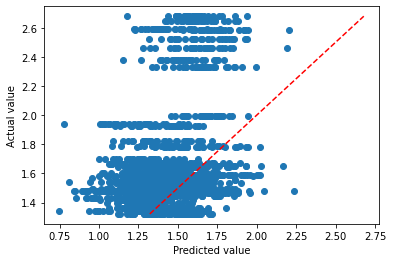

In [257]:
model.eval()
y_vals = []
y_preds = []
with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        y_vals.append(y)
        s, W, mu, logvar, y_hat = model(x)
        y_preds.append(y_hat)
    
y_vals = torch.cat(y_vals).cpu().detach()
y_preds = torch.cat(y_preds).cpu().detach()
perfect = np.linspace(min(y_vals), max(y_vals), 100)
plt.plot(perfect, perfect, '--', color='red')
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
print("R2: ", r2_score(y_vals, y_preds))
print("MSE: ", (y_vals-y_preds).pow(2).mean().item())
plt.scatter(y_preds, y_vals)
plt.show()

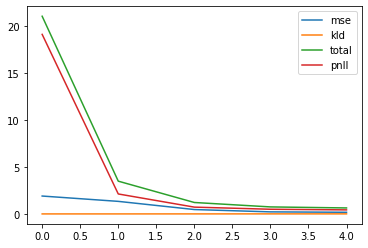

In [258]:
plt.plot(loss_results['train']['mse'], label='mse')
plt.plot(loss_results['train']['kld'], label='kld')
plt.plot(loss_results['train']['total'], label='total')
plt.plot(loss_results['train']['pnll'], label='pnll')
plt.legend()
plt.show()

R2:  -0.4162473659325989


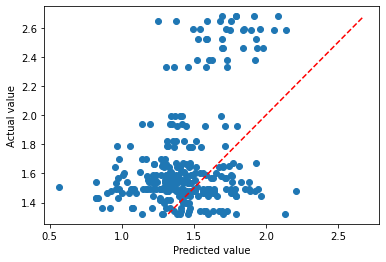

In [259]:
model.eval()
y_vals = []
y_preds = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y_vals.append(y)
        s, W, mu, logvar, y_hat = model(x)
        y_preds.append(y_hat)
    
y_vals = torch.cat(y_vals).cpu().detach()
y_preds = torch.cat(y_preds).cpu().detach()
perfect = np.linspace(min(y_vals), max(y_vals), 100)
plt.plot(perfect, perfect, '--', color='red')
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.scatter(y_preds, y_vals)
print("R2: ", r2_score(y_vals, y_preds))
plt.show()

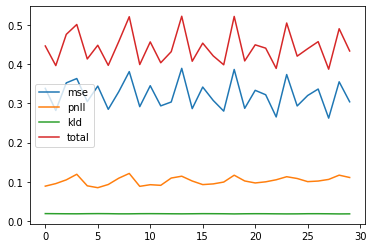

In [253]:
plt.plot(loss_results['val']['mse'], label='mse')
plt.plot(loss_results['val']['pnll'], label='pnll')
plt.plot(loss_results['val']['kld'], label='kld')
plt.plot(loss_results['val']['total'], label='total')
plt.legend()
plt.show()

In [254]:
min(loss_results['val']['mse'])

0.26210375272723674

#### Questions I want to answer
How does the number of components impact the PNLL?
* I expect that more components will decrease the PNLL. So in theory, we can find the optimal number of components to keep the PNLL down, so that the right number of topics can be learned, and the one topic that correlates with AQI can be extracted.